# 『ガウス過程と機械学習』3章の図に関する実装

## 図3.1の実装
基底関数を動径基底関数
$$
\phi_h (x) = \exp{\{-\frac{(x-\mu_h)^2}{\sigma^2}\}}\ , \ (h = -H , \frac{1}{H} - H , ... , - \frac{1}{H}+H , H)
$$

としたときの回帰問題をサンプルとして提示します．


In [10]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [11]:
plt.style.available # スタイル確認

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [12]:
x = np.arange(-4 , 5 , 0.1 )
x

array([-4.00000000e+00, -3.90000000e+00, -3.80000000e+00, -3.70000000e+00,
       -3.60000000e+00, -3.50000000e+00, -3.40000000e+00, -3.30000000e+00,
       -3.20000000e+00, -3.10000000e+00, -3.00000000e+00, -2.90000000e+00,
       -2.80000000e+00, -2.70000000e+00, -2.60000000e+00, -2.50000000e+00,
       -2.40000000e+00, -2.30000000e+00, -2.20000000e+00, -2.10000000e+00,
       -2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
       -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
       -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        3.55271368e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
        8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,
        1.20000000e+00,  

In [13]:
mu = np.arange(-3 , 5 , 1 )
mu

array([-3, -2, -1,  0,  1,  2,  3,  4])

In [14]:
sigma = 1

In [15]:
omega = np.array([-0.48 , -0.64 , 0.41 , 0.28 , 0.57 , 0.50 , -0.26 , 0.60])
omega

array([-0.48, -0.64,  0.41,  0.28,  0.57,  0.5 , -0.26,  0.6 ])

In [16]:
def radial_basis_function(x , mu_h , sigma):
    phi = np.exp(- (x - mu_h / sigma)**2)
    return phi

In [17]:
def radial_basis_function_vecteor(x , mu , sigma):# xとmuは同じ次元のベクトル
    phi_vector = []
    length = len(mu)
    # ベクトルの各要素に対して基底関数を計算
    for i in range(length) :
        phi_vector.append(radial_basis_function(x , mu[i] , sigma))
    return phi_vector

In [18]:
def regression_function(x , omega , mu , sigma):
    phi_vector = radial_basis_function_vecteor(x , mu , sigma)
    y = np.dot(omega , phi_vector)
    return y
x1 = np.arange(-2, 2, 0.05) # x1点として[-2, 2]まで0.05刻みでサンプル
x2 = np.arange(-2, 2, 0.05)  # x2点として[-2, 2]まで0.05刻みでサンプル
x1, x2 = np.meshgrid(x1, x2)  # 上述のサンプリング点(x1,x2)を使ったメッシュ生成


In [19]:
phi_vector = radial_basis_function_vecteor(x , mu , sigma)
phi_vector

[array([3.67879441e-01, 4.44858066e-01, 5.27292424e-01, 6.12626394e-01,
        6.97676326e-01, 7.78800783e-01, 8.52143789e-01, 9.13931185e-01,
        9.60789439e-01, 9.90049834e-01, 1.00000000e+00, 9.90049834e-01,
        9.60789439e-01, 9.13931185e-01, 8.52143789e-01, 7.78800783e-01,
        6.97676326e-01, 6.12626394e-01, 5.27292424e-01, 4.44858066e-01,
        3.67879441e-01, 2.98197279e-01, 2.36927759e-01, 1.84519524e-01,
        1.40858421e-01, 1.05399225e-01, 7.73047404e-02, 5.55762126e-02,
        3.91638951e-02, 2.70518469e-02, 1.83156389e-02, 1.21551783e-02,
        7.90705405e-03, 5.04176026e-03, 3.15111160e-03, 1.93045414e-03,
        1.15922917e-03, 6.82328053e-04, 3.93669041e-04, 2.22629857e-04,
        1.23409804e-04, 6.70548243e-05, 3.57128496e-05, 1.86437423e-05,
        9.54016287e-06, 4.78511739e-06, 2.35257520e-06, 1.13372714e-06,
        5.35534780e-07, 2.47959602e-07, 1.12535175e-07, 5.00621802e-08,
        2.18295780e-08, 9.33028757e-09, 3.90893843e-09, 1.605228

In [20]:
y = regression_function(x , omega , mu , sigma)
y

array([-0.18825351, -0.23075371, -0.2780037 , -0.32934937, -0.38388373,
       -0.44048705, -0.49788378, -0.55470712, -0.60956079, -0.66106775,
       -0.70789881, -0.74877935, -0.78247835, -0.80778992, -0.823521  ,
       -0.82849994, -0.82161696, -0.8019013 , -0.76863088, -0.72146118,
       -0.66055278, -0.58667324, -0.50125012, -0.40635768, -0.30462951,
       -0.19910127, -0.09299891,  0.0105029 ,  0.10852249,  0.19868359,
        0.27927348,  0.34933075,  0.40865651,  0.45775395,  0.49770911,
        0.53003196,  0.55647847,  0.57887343,  0.59895016,  0.61821835,
        0.63786641,  0.65870062,  0.68112036,  0.70512649,  0.73035881,
        0.75615713,  0.78163888,  0.80578527,  0.82752632,  0.84581585,
        0.85968832,  0.86829346,  0.87090858,  0.86693421,  0.85588263,
        0.83737152,  0.81113398,  0.77705299,  0.73522137,  0.68602147,
        0.63021091,  0.56899629,  0.50407445,  0.43762392,  0.37223441,
        0.31077177,  0.25618508,  0.21127276,  0.17843148,  0.15

Text(0.5, 1.0, 'regression_function')

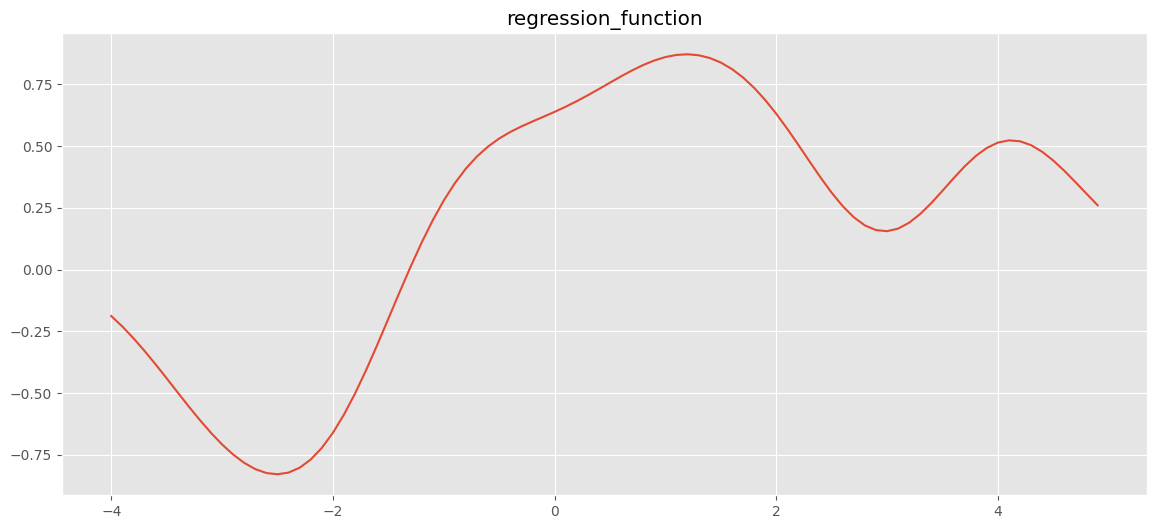

In [21]:
fig , ax = plt.subplots(figsize=(14, 6))

ax.plot(x , y , label = "regression_function")
ax.set_title("regression_function")

## 図3.4の実装
ガウス過程の概念図を実装します．

ただし，今回カーネルは以下のように定義します．
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{'})
$$

In [22]:
Theta_1 , Theta_2 , Theta_3 = 10 , 1 , 0.1

In [23]:
# カーネル関数を定義
def kernel(x, x_prime, p, q, r):
    if x == x_prime:
        delta = 1
    else:
        delta = 0
    
    kernel =  p*np.exp(-1 * (x - x_prime)**2 / q) + (r * delta) 
    return kernel

In [24]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1, Theta_2, Theta_3)
    return K

In [25]:
kai = np.arange(-4 , 5 , 0.1 )

In [26]:
K = compute_kernel(kai , Theta_1 , Theta_2 , Theta_3)

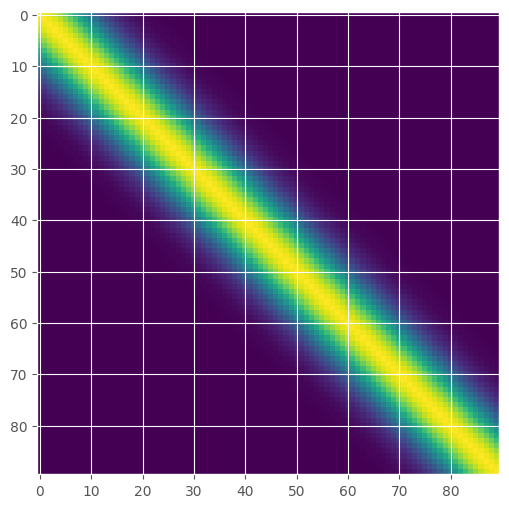

In [27]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

# 図3.11の実装

先程定義したカーネルに対して図3.11のようなサンプルを生成します．

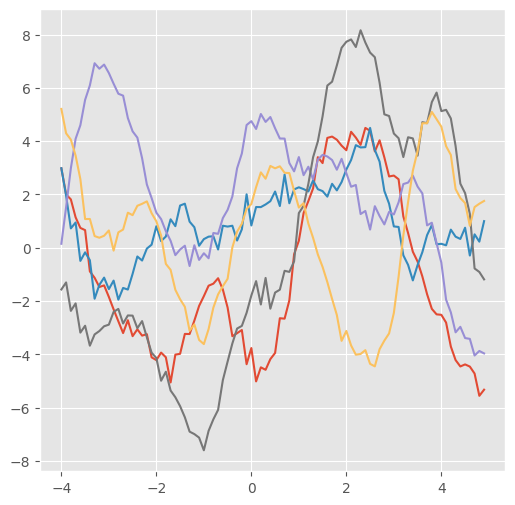

In [28]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
plt.show()


### 線形カーネル
$$
k(x , x^{'}) = \theta_1 x x^{'}
$$

In [29]:
# カーネル関数を定義
def kernel(x, x_prime, p):
    return p * np.dot(x, x_prime)

In [30]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1)
    return K

In [31]:
kai = np.arange(-4 , 5 , 0.1 )

In [32]:
K = compute_kernel(kai , Theta_1)

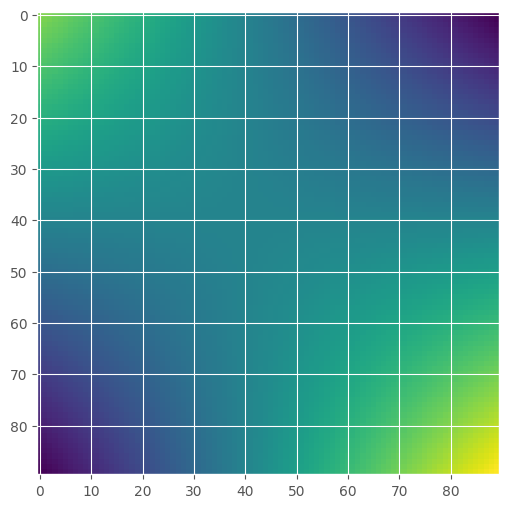

In [33]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

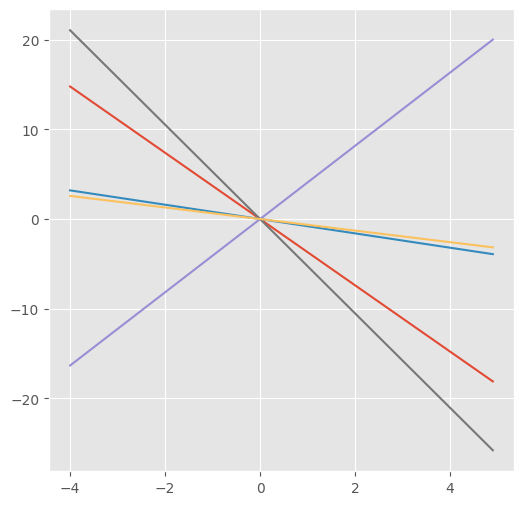

In [34]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
plt.show()

### 指数カーネル
$$
k(x , x^{'}) = \exp{\left( - \frac{|x - x^{'}|}{\theta} \right)}
$$

In [59]:
# カーネル関数を定義
def kernel(x, x_prime, p):
    return np.exp(-1 * np.abs(x - x_prime) / p)

In [60]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1)
    return K

In [61]:
kai = np.arange(-10 , 10 , 0.1 )

In [62]:
K = compute_kernel(kai , Theta_1)

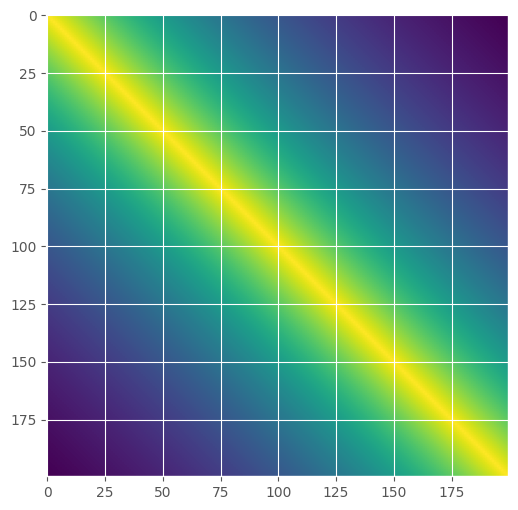

In [63]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

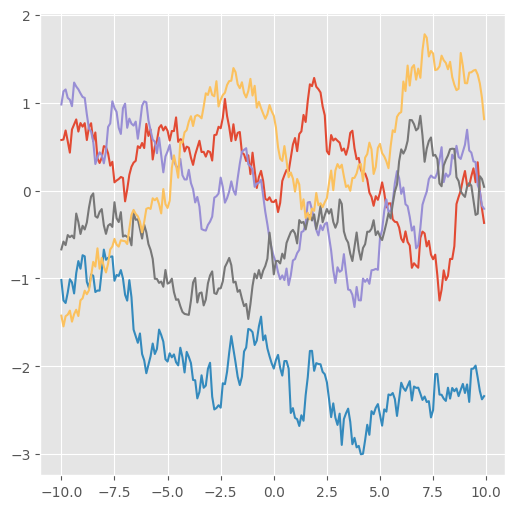

In [64]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
plt.show()

### 周期カーネル
$$
k(x , x^{'}) = \exp{\left( \theta_1 \cos(|x-x^{\prime}| / \theta_2)\right)}
$$

In [42]:
# カーネル関数を定義
def kernel(x, x_prime, p):
    return np.exp(p * np.cos(x - x_prime) / p)

In [43]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1)
    return K

In [55]:
kai = np.arange(-20 , 20 , 0.1 )

In [56]:
K = compute_kernel(kai , Theta_1)

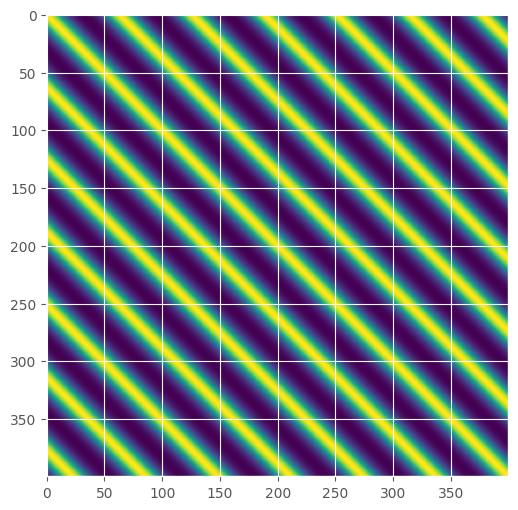

In [57]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

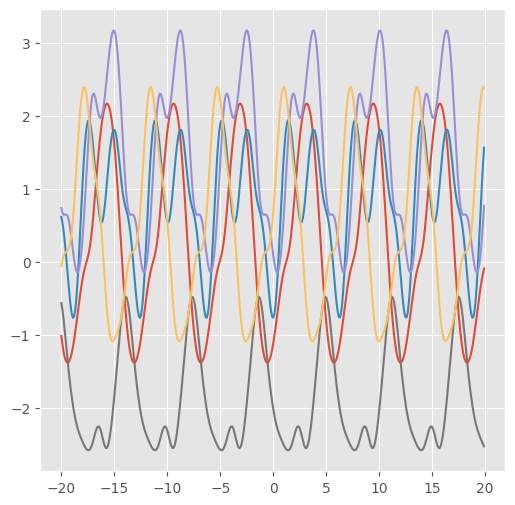

In [58]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
plt.show()